# Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestRegressor

# Preparing data

In [2]:
tfnet = pd.read_csv('~/Desktop/BINF305/assignment_week_39/network_tf_gene.txt', sep='\t', header=None,
                    skiprows=34, usecols=[0,1,2,4], names=['TF', 'target', 'sign', 'evidence'])

exp = pd.read_csv('~/Desktop/BINF305/assignment_week_39/E_coli_v4_Build_6/avg_E_coli_v4_Build_6_exps466probes4297.tab',
                  sep='\t', header=None, skiprows=1)


# Preparing expression data
exp[0] = exp[0].str.split('_').str[0]
exp[0] = exp[[0]].applymap(lambda x: x.upper())
exp[0] = exp.sort_values(by = 0)

# upper case mapping
tfnet.sort_values(by = 'TF')
tfnet.TF = [x.upper() for x in tfnet.TF]
tfnet.target = [x.upper() for x in tfnet.target]

# filtering: strong evidence, unambiguous signs,removal of autoregulated tfs and drop duplicates
tfnet = tfnet[(tfnet.evidence == 'Strong') & ((tfnet.sign == '+') | (tfnet.sign == '-'))]
tfnet = tfnet[tfnet.TF != tfnet.target]
tfnet = tfnet.drop_duplicates(subset=['TF', 'target'])

# Filtering that assures both tf and target is in expression data gene set
tfnet = tfnet[tfnet.TF.isin(exp[0]) & tfnet.target.isin(exp[0])]

TFs = tfnet.TF.unique()
nodes = pd.concat([tfnet.TF,tfnet.target],join='outer').unique()
nodes.sort()

# Create set of common genes
common_genes = np.intersect1d(nodes, np.array(exp[0]))
exp = exp[exp[0].isin(common_genes)]
print("Number of genes present in both datasets: ", len(common_genes))

node_map = pd.Series(np.arange(common_genes.size),index=common_genes)

# Creating correlation matrix
expcorr = (exp.transpose()[1:]).astype(float)
expcorr = expcorr.corr()
expcorr = np.array(expcorr)

Number of genes present in both datasets:  849


# Creating adjacency matrix

In [3]:
I = np.array([node_map.loc[x] for x in tfnet.TF])
J = np.array([node_map.loc[x] for x in tfnet.target])
V = np.ones_like(tfnet.sign)
V[tfnet.sign=='-'] = -1
C = sp.coo_matrix((V,(I,J)),shape=[common_genes.size,common_genes.size],dtype=np.int8)
A = np.abs(C)

# Organizing data for plotting

In [4]:
I, J = C.nonzero() 
C_arr = C.toarray()[I,J]

non_zero_indices = list(zip(I,J))

I_act, J_act = [list(a) for a in zip(*[(I[i], J[i]) for i in range(len(C_arr)) if C_arr[i] == 1])]
I_rep, J_rep = [list(a) for a in zip(*[(I[i], J[i]) for i in range(len(C_arr)) if C_arr[i] == -1])]

indices = [(i, j) for i in range (C.shape[0]) for j in range(C.shape[1])]
zero_indices = set(indices).difference(non_zero_indices)
I_rest, J_rest = list(zip(*set(zero_indices).difference(non_zero_indices)))

activators = expcorr[I_act, J_act]
repressors = expcorr[I_rep, J_rep]
rest = expcorr[I_rest, J_rest]

# Plot of labeled correlation data

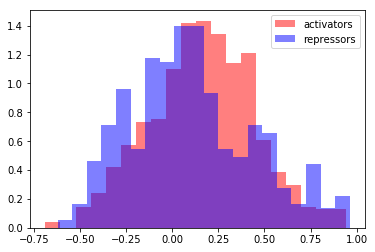

In [5]:
plot_1 = plt.hist(activators, bins=20, density = True, color='r', alpha=0.5, label='activators')
plot_2 = plt.hist(repressors, bins=20, density = True, color='b', alpha=0.5, label='repressors')
# plot_3 = plt.hist(rest, bins=20, density=True, color='g', alpha=0.5, label='False relations')
_ = plt.legend()

# Correlation matrix scores

In [6]:
num_nodes = len(common_genes)
tf_indices = node_map.loc[TFs]

for i in range(expcorr.shape[0]):
    expcorr[i][i] = 0
x = abs(expcorr[tf_indices]).flatten()    
y = abs(C.toarray()[tf_indices]).flatten()

precision_expr, recall_expr, thresholds = precision_recall_curve(y, x)
fpr_expr, tpr_expr, thresholds = roc_curve(y, x)

# Random forest regression scores

In [7]:
x = exp[exp[0].isin(tf_indices.index)].transpose()[1:]
y = exp.copy().transpose()[1:]

feature_scores = []
for i in range(y.shape[1]):
    regr  = RandomForestRegressor(max_depth = 2, random_state = 0, n_estimators = 10)
    regr.fit(x, y.iloc[:,i])
    feature_scores.append(regr.feature_importances_)
    
feature_scores = np.array(feature_scores).transpose()
for i in range(feature_scores.shape[0]):
    feature_scores[i,tf_indices[i]] = 0

x = feature_scores.flatten()
y = abs(C.toarray()[tf_indices]).flatten()

precision_rfr, recall_rfr, thresholds = precision_recall_curve(y, x)
fpr_rfr, tpr_rfr, thresholds = roc_curve(y, x)

# Plots

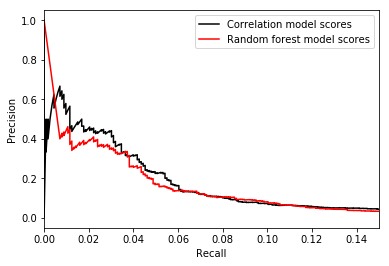

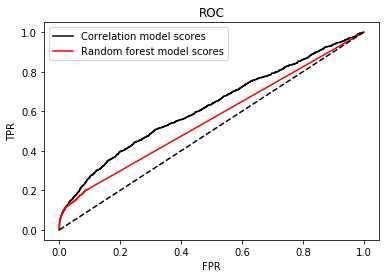

In [13]:
plt.plot(recall_expr, precision_expr, 'k-', label = 'Correlation model scores')
plt.plot(recall_rfr, precision_rfr, 'r-', label = 'Random forest model scores')
plt.xlim(0,0.15)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

plt.plot(fpr_expr,tpr_expr, 'k-', label = 'Correlation model scores')
plt.plot(fpr_rfr, tpr_rfr, 'r-', label = 'Random forest model scores')
plt.title('ROC')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()